Copy 1 es el fichero funcional pero con MOSFETs envejecidos leídos desde el excel importado (léase descripción en Copy 1).
La principal diferencia con esta versión es la limpieza de ciertas partes innecesarias
Otra diferencia es la introduccción de un factor de envejecimiento para no leer de Tabla MOSFET más allá del original
También se han eliminado variables enterradas.
Se han incluido las pérdidas de la bobina en el cálculo

Copy 2 es el fichero funcional pero los valores eficaces de los MOSFETs estaban mal calculados.
En esta versión, se calculan suponiendo un rizado por la bobina despreciable.

VERSION ACTUAL
Incluye mejoras en el cálculo de los valores eficaces y corrige una errata en el cáuclo de Iin en ciertas llamadas a función, que faltaba un paréntesis para dar el orden adecuado.

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import scipy.integrate as integrate
import numpy as np
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.patches as patches
import random

import MOS_design as MD
import mag_design as MGD
sns.set(style="darkgrid")

# Variables de entrada y configuración

In [109]:
Vbus=100 # Tensión en el bus
Vsa_min=80 #Máximo y minimo de la tensión del panel solar
Vsa_max=150
fsw=180e3 #100000 # Frecuencia de conmutación
T=1/fsw
P=500 # Potencia nominal
L_ind=84/1000000

size_D1=13 #Número de elementos en los vectores de D1 y D2.
size_D2=11

# Estos no son límites de operación, que vienen definidos por las variables de arriba. Estos son límites de representación
# de las gráficas como los mapas de calor.
D1_min_sh=0.6
D1_max_sh=1
D2_min_sh=0
D2_max_sh=0.4

D1_nom=0.8
D2_nom=0.2
D1_max=0.95
D2_min=0.05


phi_bob=0.4 #Desfase entre las señales de gobierno D1 y D2.
Lim_sup_D1=0.95 # Límites máximos de operación de los ciclos de trabajo
Lim_inf_D2=0.05

# MOSFET seleccionados en la implementación, según la tabla importada de Excel.
M1_index=53
M2_index=53
M3_index=53
M4_index=53
Mprot_index=54 

#Características del driver de los MOSFETs (paera pérdidas de conmutación)
Vdrvr=20
Idrvr=4

# Máximo envejecimiento
aging=1.1 #Sólo como ejemplo en ciertas partes.
aging_extra=1.2

aging_max=0.12 # Tanto por uno. FIjado según artículo de DUsmez Remaining useful...
aging_steps=6 #Número de muestras a la hora de construir la base de datos
elements=30 # Núemro de muestras tomadas en la curva de péridas en función de la ganancia

error_sense=50.0 # en tanto por mil

# Del material magnético y el núcleo se fija un E30/15/7 3F3
c_ind=6.198/10000000000000
x_ind=1.721
y_ind=2.736
Vol_ind=0.000004
N_ind=40
Ae_ind=0.00006
fw_ind=0.3
WA_ind=0.00009
lm_ind=0.056
rho=1/57000000
Awire_ind=WA_ind*fw_ind/N_ind
Lwire_ind=N_ind*lm_ind

# Definición de funciones para la operación del convertidor

In [7]:
# GANANCIA ESTÁTICA, TENSIÓN DE SALIDA ESTÁTICA
def Gain(D1,D2):
    return D1/(1-D2)

def Vin_f(Vout,D1,D2):
    return Vout*(1-D2)/D1

def D2_f(Vin,Vout,D1):
    return 1-Vin/Vout*D1

def D1_f(Vin,Vout,D2):
    return (1-D2)*Vout/Vin


# EVOLUCIÓN DE CORRIENTES POR INTERVALOS
# En el ejemplo posterior puede verse el significado de phi, que es el desfase entre el comienzo de D1 y el D2.

# Este primer período siempre es igual
def Ip1(t,L,Vin,Vout,I1,phi,D1,D2):
    return I1+(Vin-Vout)*t/L

#El segundo período depende de phi+D2 respecto a D1 en su límite de validez, pero no en la ecuación.
def Ip2(t,L,Vin,Vout,I2,phi,D1,D2):
    if (phi<D1):
        return I2+Vin*t/L
    else:
        return I2-Vout*t/L

#El tercer período depende de phi+D2 respecto a D1. 
def Ip3(t,L,Vin,Vout,I3,phi,D1,D2):
    if phi+D2<D1:
        return I3+(Vin-Vout)*t/L
    else:
        return I3+t*0

# Este último período siempre es igual
def Ip4(t,L,Vin,Vout,I4,phi,D1,D2):
    return I4-Vout*t/L



# DEFINICIÓN DE INTERVALOS DE TIEMPO DE CADA PERIODO
# Son funciones auxiliares empleadas por la siguiente función. Generan conjuntos de puntos. Es en general,
#no solo para este caso de 4-switch buuck-boost

def t1(D1,D2,phi,T):
    if (phi<D1):
        return np.linspace(0,T*phi)
    else:
        return np.linspace(0,T*D1)
def t2(D1,D2,phi,T):
    if (phi>D1):
        return np.linspace(T*D1,phi*T)
    elif (D2+phi>D1):
        return np.linspace(T*phi,D1*T)
    else:
        return np.linspace(T*phi,(D2+phi)*T)
def t3(D1,D2,phi,T):
    if (phi>D1):
        return np.linspace(phi*T,(D2+phi)*T)
    elif D2+phi>D1:
        return np.linspace(D1*T,(D2+phi)*T)
    else:
        return np.linspace((D2+phi)*T,D1*T)
def t4(D1,D2,phi,T):
    if D2+phi>D1:
        return np.linspace((D2+phi)*T,T)
    else:
        return np.linspace(D1*T,T)
    

# Esta función devuelve los intervalos de tiempo t1 a t4 y los valores de comienzo y de final dedichos intervalos.
#Es decir, devuelve 12 elementos, agrupados de 3 en 3. 
# Validada de forma indirecta mendiante la ecuación Iind_avg. SE DEBE MEJORAR LA VALIDACIÓN
def intervals(D1,D2,phi,T):
    t1_x=t1(D1,D2,phi,T)
    t2_x=t2(D1,D2,phi,T)
    t3_x=t3(D1,D2,phi,T)
    t4_x=t4(D1,D2,phi,T)
    t1_ini=t1_x[0]
    t2_ini=t2_x[0]
    t3_ini=t3_x[0]
    t4_ini=t4_x[0]
    array_length = len(t1_x)
    t1_end = t1_x[array_length - 1]
    array_length = len(t2_x)
    t2_end = t2_x[array_length - 1]
    array_length = len(t3_x)
    t3_end = t3_x[array_length - 1]
    array_length = len(t4_x)
    t4_end = t4_x[array_length - 1]
    return t1_x,t1_ini,t1_end,t2_x,t2_ini,t2_end,t3_x,t3_ini,t3_end,t4_x,t4_ini,t4_end
    

# VALORES DE CORRIENTE MEDIA, DE COMIENZO, ETC

# Valor medio de corriente por bobina
# Se debe indicar los valores de corriente al comienzo de cada intervalo y la duración de cada uno de dichos intervalos
# OK Validada en el ejemplo, lo que de forma indirecta valida también la ecuación anterior.
def Iind_avg(I1_ini,I2_ini,I3_ini,I4_ini,T1,T2,T3,T4):
    return 0.5*(I1_ini*(T4+T1)+I2_ini*(T1+T2)+I3_ini*(T2+T3)+I4_ini*(T3+T4))/(T1+T2+T3+T4)


# Valor final de cada intervalo de corriente por la bobina
# Se debe dar la bobina, tensiones de entrada y salida, el valor de comienzo del periodo I1_ini, ciclos de trabajo,
# desfase y periodo

def currents(L,Vin,Vout,I1_ini,D1,D2,phi,T):
    t=intervals(D1,D2,phi,T)
    Ip4_end=I1_ini
    Ip1_end=Ip1(t[2],L,Vin,Vout,I1_ini,phi,D1,D2)
    Ip2_end=Ip2(t[5]-t[2],L,Vin,Vout,Ip1_end,phi,D1,D2)
    Ip3_end=Ip3(t[8]-t[5],L,Vin,Vout,Ip2_end,phi,D1,D2)
    return Ip1_end,Ip2_end,Ip3_end,Ip4_end

# Corriente inicial del periodo (no de un intervalo):
def Iini(L,Vin,Iin,Vout,D1,D2,phi,T):
    c=currents(L,Vin,Vout,0,D1,D2,phi,T)
    i=intervals(D1,D2,phi,T)
    if (c[3]>0):
        A1=0.5*(c[0]-0)*(i[2]-i[1])+0.5*abs(c[1]+c[0])*(i[5]-i[4])+min(c[0],c[1])*(i[5]-i[4])+0.5*abs(c[2]-c[1])*(i[8]-i[7])+min(c[2],c[1])*(i[8]-i[7])+0.5*c[2]*(i[11]-i[10])
    else:
        A1=0.5*(c[0]-0)*(i[2]-i[1])+0.5*abs(c[1]+c[0])*(i[5]-i[4])+min(c[0],c[1])*(i[5]-i[4])+0.5*abs(c[2]-c[1])*(i[8]-i[7])+min(c[2],c[1])*(i[8]-i[7])+0.5*c[2]*(i[11]-i[10])
    Iini=(Iin*T/D1-A1)/T
    Iini=Iin/D1-A1/T
    return Iini

# Se basa en la anterior, current function, pero sin dar valor inicial
def currents_L(L,Vin,Vout,Iin,D1,D2,phi,T):
    t=intervals(D1,D2,phi,T)
    Ip4_end=Iini(L,Vin,Iin,Vout,D1,D2,phi,T)
    Ip1_end=Ip1(t[2],L,Vin,Vout,Ip4_end,phi,D1,D2)
    Ip2_end=Ip2(t[5]-t[2],L,Vin,Vout,Ip1_end,phi,D1,D2)
    Ip3_end=Ip3(t[8]-t[5],L,Vin,Vout,Ip2_end,phi,D1,D2)
    return Ip1_end,Ip2_end,Ip3_end,Ip4_end

# Valor eficaz y valor medio de un intervalo (no del período completo)
def Irms_sec(fsw,tfin,tini,Ifin,Iini):
    dt=tfin-tini
    dI=abs(Ifin-Iini)
    return np.sqrt(fsw*(Iini**2*dt+Iini*dI*dt+dI**2*dt/3))

def Iavg_sec(fsw,tfin,tini,Ifin,Iini):
    dt=tfin-tini
    dI=Ifin-Iini
    return 0.5*(Iini+Ifin)*(tfin-tini)*fsw

def Irms_Mi(D1,D2,phi,fsw,tfin1,tfin2,tfin3,tfin4,tini1,Ifin1,Ifin2,Ifin3,Ifin4):
    if phi+D2>D1:
        Irms_M1=np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2)
        Irms_M2=np.sqrt(Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2)
        Irms_M3=np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2)
        Irms_M4=np.sqrt(Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2)

    else:
        Irms_M1=np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2)
        Irms_M2=np.sqrt(Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2)
        Irms_M3=np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2)
        Irms_M4=np.sqrt(Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2)
        
    return Irms_M1,Irms_M2,Irms_M3,Irms_M4


## Ejemplo de uso de las funciones principales

(100.0,
 3.897707231040565,
 3.897707231040565,
 6.102292768959437,
 3.897707231040565,
 5.000000000000001,
 5.862908894672509,
 0.0,
 0.0,
 4.115419496600567,
 4.1757661661340615,
 5.862908894672509,
 0.0)

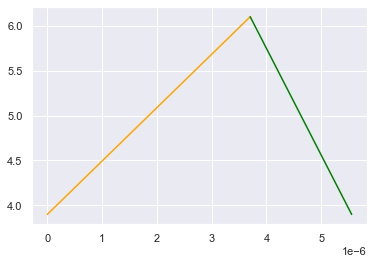

In [8]:
#Example
D1_ex=100/150
D2_ex=0
phi_ex=0
fsw_ex=180000
T_ex=1/fsw_ex
Vin_ex=150
P_ex=500
Iin_ex=P_ex/Vin_ex
L_ex=84/1000000


Vout_ex=Vin_ex*Gain(D1_ex,D2_ex)

Ip1_ini_ex= Iini(L_ex,Vin_ex,Iin_ex,Vout_ex,D1_ex,D2_ex,phi_ex,T_ex)

outcome_ex=intervals(D1_ex,D2_ex,phi_ex,T_ex)

t1_x_ex=outcome_ex[0]
t2_x_ex=outcome_ex[3]
t3_x_ex=outcome_ex[6]
t4_x_ex=outcome_ex[9]


t1_ini_ex=outcome_ex[1]
t2_ini_ex=outcome_ex[4]
t3_ini_ex=outcome_ex[7]
t4_ini_ex=outcome_ex[10]

t1_end_ex = outcome_ex[2]
t2_end_ex = outcome_ex[5]
t3_end_ex = outcome_ex[8]
t4_end_ex = outcome_ex[11]

Ip1_end_ex,Ip2_end_ex,Ip3_end_ex,Ip4_end_ex=currents_L(L_ex,Vin_ex,Vout_ex,Iin_ex,D1_ex,D2_ex,phi_ex,T_ex)

plt.plot(t1_x_ex,Ip1(t1_x_ex,L_ex,Vin_ex,Vout_ex,Ip4_end_ex,phi_ex,D1_ex,D2_ex),'blue')
plt.plot(t2_x_ex,Ip2(t2_x_ex-t1_end_ex,L_ex,Vin_ex,Vout_ex,Ip1_end_ex,phi_ex,D1_ex,D2_ex),'red')
plt.plot(t3_x_ex,Ip3(t3_x_ex-t2_end_ex,L_ex,Vin_ex,Vout_ex,Ip2_end_ex,phi_ex,D1_ex,D2_ex),'orange')
plt.plot(t4_x_ex,Ip4(t4_x_ex-t3_end_ex,L_ex,Vin_ex,Vout_ex,Ip3_end_ex,phi_ex,D1_ex,D2_ex),'green')

Iavg_ex=Iind_avg(Ip4_end_ex,Ip1_end_ex,Ip2_end_ex,Ip3_end_ex,t1_end_ex-t1_ini_ex,t2_end_ex-t2_ini_ex,t3_end_ex-t3_ini_ex,t4_end_ex-t4_ini_ex)

Irms_1=Irms_sec(fsw_ex,t1_end_ex,t1_ini_ex,Ip1_end_ex,Ip4_end_ex)
Irms_2=Irms_sec(fsw_ex,t2_end_ex,t2_ini_ex,Ip2_end_ex,Ip1_end_ex)
Irms_3=Irms_sec(fsw_ex,t3_end_ex,t3_ini_ex,Ip3_end_ex,Ip2_end_ex)
Irms_4=Irms_sec(fsw_ex,t4_end_ex,t4_ini_ex,Ip4_end_ex,Ip3_end_ex)

ch1,ch2,ch3,ch4=Irms_Mi(D1_ex,D2_ex,phi_ex,fsw_ex,t1_end_ex,t2_end_ex,t3_end_ex,t4_end_ex,t1_ini_ex,Ip1_end_ex,Ip2_end_ex,Ip3_end_ex,Ip4_end_ex)
Irms_tot=np.sqrt(Irms_1**2+Irms_2**2+Irms_3**2+Irms_4**2)
Irms_in=np.sqrt(Irms_1**2+Irms_2**2)
Iavg_in=Iavg_sec(fsw_ex,t1_end_ex,t1_ini_ex,Ip1_end_ex,Ip4_end_ex)+Iavg_sec(fsw_ex,t2_end_ex,t2_ini_ex,Ip2_end_ex,Ip1_end_ex)
Vout_ex,Ip1_end_ex,Ip2_end_ex,Ip3_end_ex,Ip4_end_ex,Iavg_ex,Irms_tot,Irms_in,Iavg_in,ch1,ch2,ch3,ch4

## Validación mediante comparación con fichero de simulación
##### El fichero empleado es Buck_Boost v1_DHB.  Se representa la imagen y los resultados mostrados por las ecuaciones desarrolladas en el script de python y aplicadas en la sección anterior "Ejemplo de uso de las ecuaciones anteriores". Tan sólo hay que copiar los valores adjuntados abajo en la celda de arriba para tener los resultados.

In [9]:
# Ciclo D2 mayor que D1 y un phi menor que D1
#  Se valida sobre buck_Boost v1_DHB
#  Se prueba con los parámetros
#  D1_ex=0.3
#  D2_ex=0.6
#  phi_ex=0.2
#  fsw_ex=100000
#  T_ex=1/fsw_ex
#  Vin_ex=10
#  P_ex=500
#  Iin_ex=P_ex/Vin_ex
#  L_ex=0.00001
# Se ajustan bastante, aunque hay una pequeña discrepancia en el valor de inicio (0.2 sobre 166 A), lo que descuadra también
# un poco el resto de valores analizados

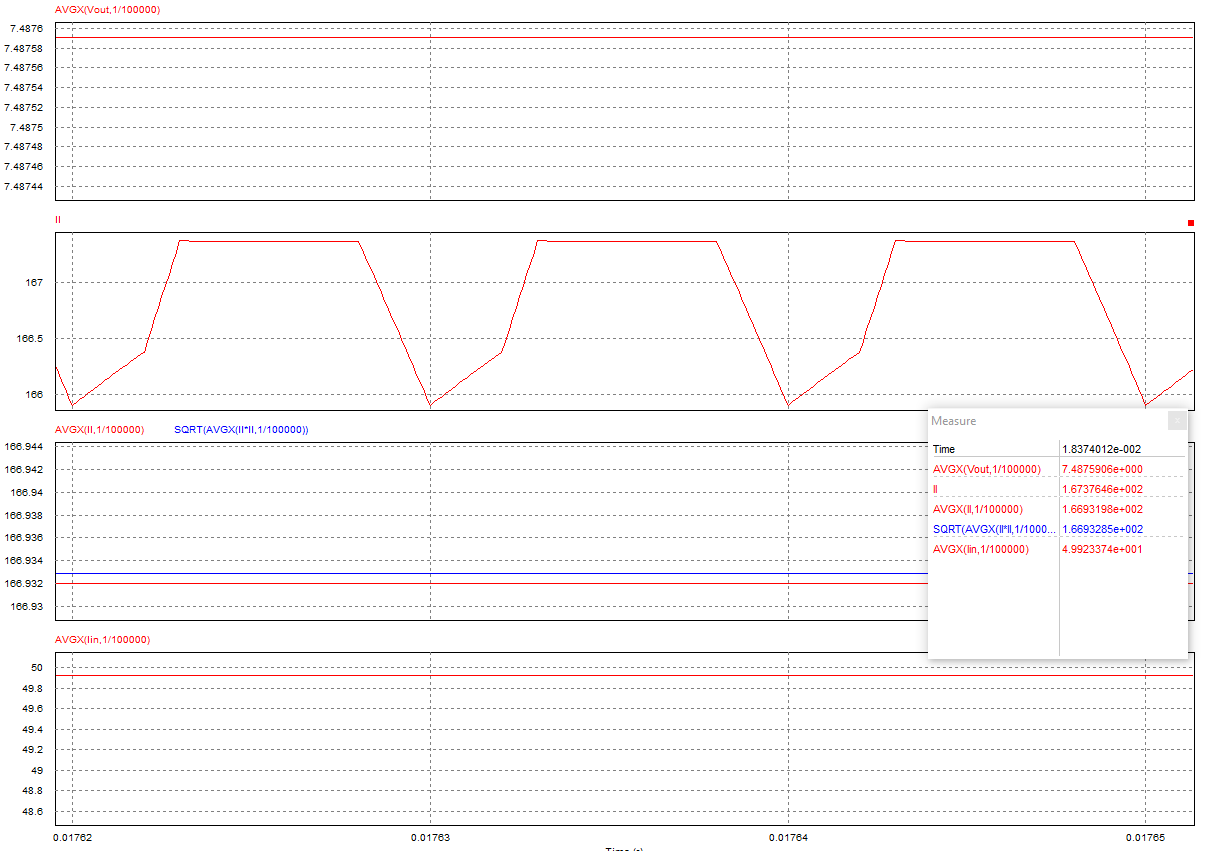

 

In [10]:
# Ciclo D2 mayor que D1 y un phi nulo. REVISAR, HAY UN DESCUADRE DE 2A EN EL VALOR MEDIO DE LA CORRIENTE POR LA BOBINA

# D1_ex=0.3
# D2_ex=0.6
# phi_ex=0.0
# fsw_ex=100000
# T_ex=1/fsw_ex
# Vin_ex=10
# P_ex=500
# Iin_ex=P_ex/Vin_ex
# L_ex=0.00001
# Los valores arrojados en el orden estándar son:
# (7.499999999999999,
#  163.66666666666666,
#  166.66666666666666,
#  166.66666666666666,
#  163.66666666666666,
#  165.61666666666667,
#  166.82289344624667,
#  90.46675264058798,
#  49.55)
# Hay algo de discrepancia, mayor que antes, aunque se maneja bien el hecho de que sólo hay tres intervalos.

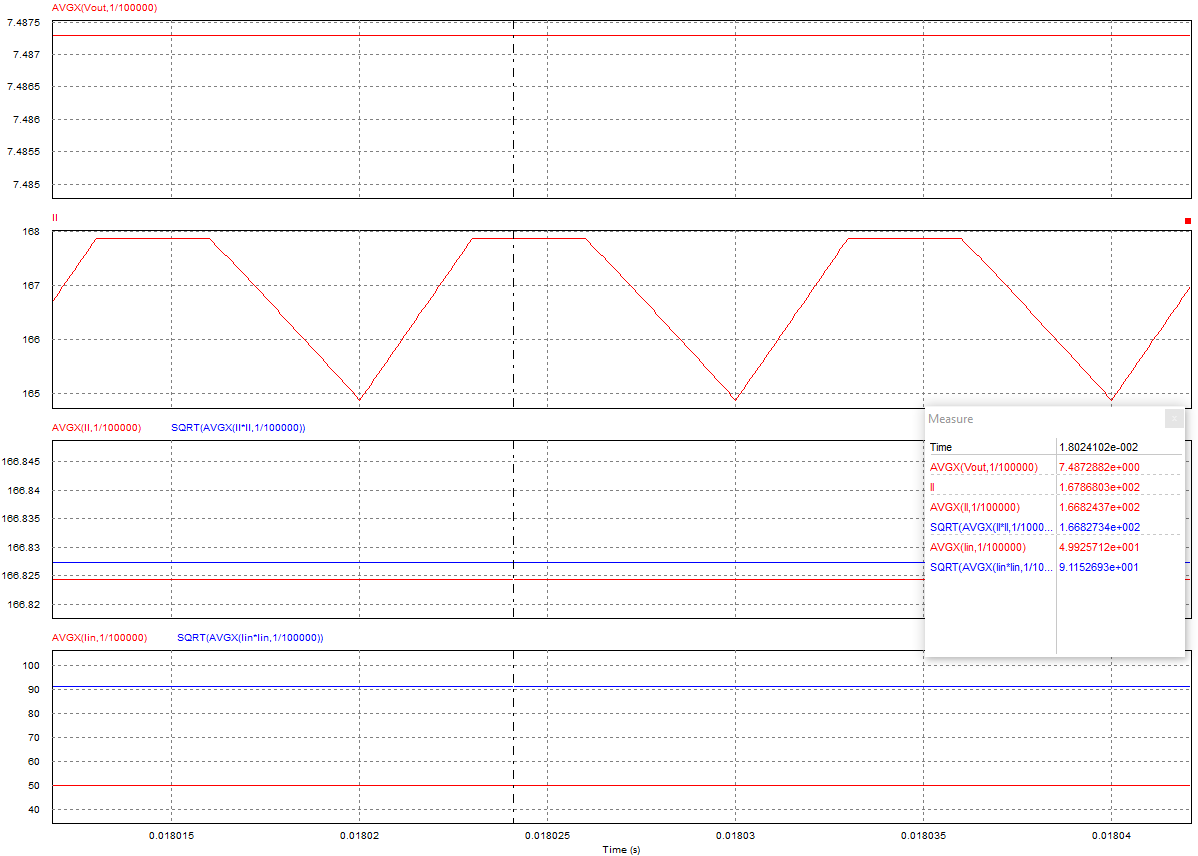

In [11]:
#D1 mayor que D2 y acabando éste antes de D1.
# D1_ex=0.6
# D2_ex=0.2
# phi_ex=0.2
# fsw_ex=100000
# T_ex=1/fsw_ex
# Vin_ex=10
# P_ex=500
# Iin_ex=P_ex/Vin_ex
# L_ex=0.00001
# Los valores arrojados en el orden estándar son:
# (7.499999999999999,
#  83.25,
#  85.25,
#  85.75,
#  82.75,
#  84.25,
#  85.4684883451205,
#  52.891240610646804,
#  33.45)
# De nuevo, todos los deltas de Il están bien, pero el punto de partida es incorrecto (+1 A).

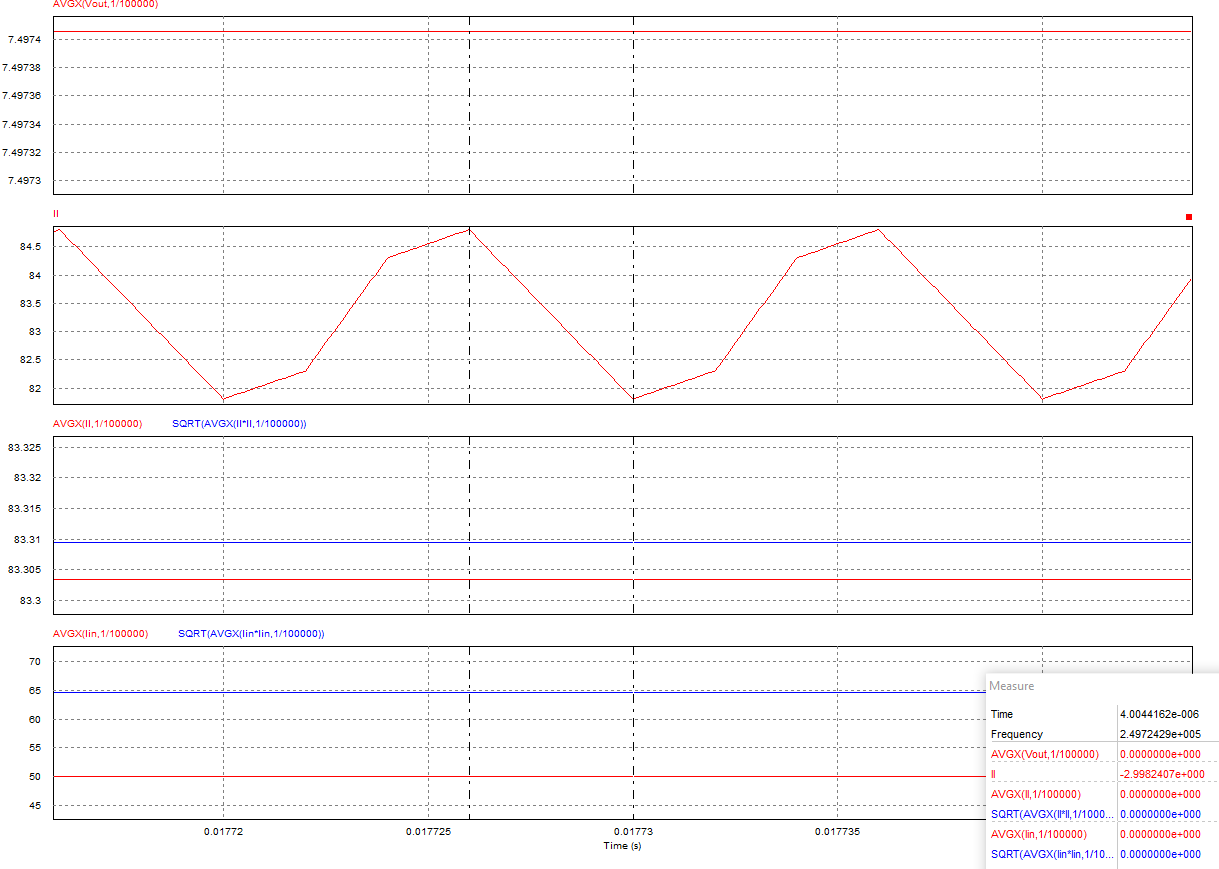

# Extracción de parámetros de MOSFETs calificados para espacio

In [107]:
# Seleccion de componentes y extracción de parámetros
# MOSFET data
MOSFETs=pd.read_excel(r'.\Space Components.xls',sheet_name="MOSFETs")
# Se usa del siguiente modo:
#MOSFETs['Id (A @25oC)'][54]=70
pd.options.display.max_columns = None
display(MOSFETs.head(20))

,Part,JEDEC Part,Manufacturer,Type,Vds (V),Id (A @25oC),Id (A @100oC),Rdson (ohms @25oC),Rdson (ohms @125oC),Ciss (pF),Coss (pF),Crss (pF),Qg (nC),Qgs (nC),Qgd (nC),td_on (ns),tr (ns),td_off (ns),tf (ns),Rth jc (oC/W),Rth jPCB (oC/W),Tj_max (oC),Package,Link,NOTES
0,IRHSNA57Z60,NaN,IR,1.0,30,75,75,0.0035,0.005075,NP,NP,NP,200,55,40,35,160,78,26,0.5,NP,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,Classified as Space Systems/Rad Hard Synchrono...
1,IRHSKNA57064,NaN,IR,1.0,60,75,75,0.0061,0.0061,NP,NP,NP,160,55,65,35,125,75,50,0.5,NP,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,NaN
2,IRHSNA57064,NaN,IR,1.0,60,56,56,0.0065,0.0065,NP,NP,NP,160,55,65,NP,NP,NP,NP,0.5,NP,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,NaN
3,IRHSLN57Z60,NaN,IR,1.0,30,75,75,0.004,0.004,NP,NP,NP,200,55,40,NP,NP,NP,NP,0.5,NP,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,NaN
4,IRHNA57160,NaN,IR,1.0,100,75,69,0.012,0.018,6440,1660,60,160,55,65,35,125,75,50,0.5,1.6,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,Classified as Space Systems/Rad Hard Power MOS...
5,IRHNA57163SE,NaN,IR,1.0,130,75,57,0.0135,0.027,5020,1490,116,160,55,75,35,125,80,50,0.5,1.6,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,NaN
6,IRHNA57064,NaN,IR,1.0,60,75,75,0.0056,0.00896,6080,2310,90,165,55,65,35,125,69,50,0.5,1.6,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,NaN
7,IRHMS67260,NaN,IR,1.0,200,45,35,0.029,0.0551,8045,953,14,240,65,60,40,60,70,30,0.6,0.81,150,TO-254AA,http://www.irf.com/product-info/datasheets/dat...,NaN
8,IRHMS67260,NaN,IR,1.0,200,56,40,0.028,0.0518,8120,949,13,240,70,60,50,150,100,50,0.5,1.6,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,NaN
9,IRHNA67160,NaN,IR,1.0,100,56,56,0.01,0.016,8690,1600,20,170,60,80,50,150,100,50,0.5,1.6,150,SMD-2,http://www.irf.com/product-info/datasheets/dat...,NaN


# Funciones de cálculo de pérdidas en los componentes

In [91]:
#MOSFET de Buck

def Losses_M1(D1,Vin,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging):
#Si no conmuta, sólo hay pérdidas de conducción
    if (D1==1):
        losses_sw=0
        losses_cond=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
        losses_tot=losses_sw+losses_cond
        return losses_tot
# Si conmuta, hay pérdidas de conducción y conmutación. Además, este dispositivo no conmuta con ZVS en encenddo ni ZCS en apagado
    elif (D1==0):
        return 0;
    else:
        losses_sw1=MD.sw_losses(Vin,Ion,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)+MD.sw_losses(Vin,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
        losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
        losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vin,fsw)
        losses_cond=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
        losses_tot=losses_sw1+losses_sw2+losses_sw3+losses_cond
        return losses_tot


# DIODO de Buck        
def Losses_M2(D1,Vin,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging):
#Si no conmuta, no hay pérdidas porque está en abierto
    if (D1==1 or D1==0):
        return 0

# Si conmuta, hay pérdidas de conducción y conmutación. Pero este dispositivo conmuta con ZVS en encenddo
    else:
        losses_sw1=MD.sw_losses(Vin,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
        losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
        losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vin,fsw)
        losses_cond=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
        losses_tot=losses_sw1+losses_sw2+losses_sw3+losses_cond
        return losses_tot

    
#DIODO de Boost
def Losses_M3(D2,Vout,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging):
    if (D2==0):
        losses_sw=0
        losses_cond=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
        losses_tot=losses_sw+losses_cond
        return losses_tot
    elif (D2==1):
        return 0;
# Si conmuta, hay pérdidas de conducción y conmutación. Además, este dispositivo conmuta con ZVS en encenddo
    else:
        losses_sw1=MD.sw_losses(Vout,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
        losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
        losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vout,fsw)
        losses_cond=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
        losses_tot=losses_sw1+losses_sw2+losses_sw3+losses_cond
        return losses_tot

    
#MOSFET de Boost
def Losses_M4(D2,Vout,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging):
    if (D2==0):
        return 0
    if (D2==1):
        return 0
# Si conmuta, hay pérdidas de conducción y conmutación. Además, este dispositivo no conmuta con ZVS en encenddo ni ZCS en apagado
    else:
        losses_sw1=MD.sw_losses(Vout,Ion,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)+MD.sw_losses(Vout,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
        losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
        losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vout,fsw)
        losses_cond=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
        losses_tot=losses_sw1+losses_sw2+losses_sw3+losses_cond
        return losses_tot
    
    
#MOSFET DE PROTECCION AÑADIDO
def Losses_prot(M_i,Irms,aging):
    losses_cond=MD.cond_losses(aging/2*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
    losses_tot=losses_cond
    return losses_tot
#HACER PARA MAGNÉTICO

def Losses_ind(c,x,y,Vol,fsw,L,Iac,N,Ae,Irms,Awire,Lwire,rho):
    Bac=L*Iac/2/N/Ae*1000
    losses_sw=MGD.core_losses(c,x,y,Bac,fsw,Vol)
    losses_cond=MGD.copper_losses(Irms,Awire,Lwire,rho)
    return losses_cond+losses_sw

# Valores típicos de c,x,y
(6.198074738669944, 1.7205492791242043, 2.736106449242652)
A=Losses_ind(6.198/10000000000000, 1.721, 2.736,0.000004,180000,84/1000000,6.61,40,0.00006,5.35,0.00009*0.3/40,40*0.056,1/57000000)

# Pérdidas en el mapa de ganancias

## Pérdidas para MOSFETs sin envejecer

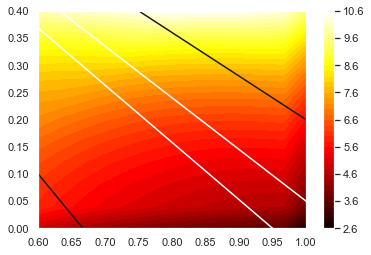

<Figure size 720x360 with 0 Axes>

In [110]:
# Se debe tener en cuenta que las pérdidas dependen de Vin, Vout, Iin y Iout, y estas deben cambiar según el duty.
# Si no fuese así, sería bastante extraño
# Fundamental calcular bien los valores eficaces de la bobina
# Se deben aplicar todas las mejoras que se apliquen en el bloque posterior


D1_r=np.linspace(D1_min_sh,D1_max_sh,size_D1)
D2_r=np.linspace(D2_min_sh,D2_max_sh,size_D2)

fig, ax = plt.subplots()

aux=[ [ 0 for i in range(size_D1) ] for j in range(size_D2) ]
for j in range(size_D2):
    for i in range(size_D1):
        c=currents_L(L_ind,Vin_f(Vbus,D1_r[i],D2_r[j]),Vbus,P/Vin_f(Vbus,D1_r[i],D2_r[j]),D1_r[i],D2_r[j],phi_bob,T)
        interv=intervals(D1_r[i],D2_r[j],phi_bob,T)
        Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1_r[i],D2_r[j],phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
        aux_M1=Losses_M1(D1_r[i],Vin_f(Vbus,D1_r[i],D2_r[j]),c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,1)
        aux_M2=Losses_M2(D1_r[i],Vin_f(Vbus,D1_r[i],D2_r[j]),c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,1)
        aux_M3=Losses_M3(D2_r[j],Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,1)
        aux_M4=Losses_M4(D2_r[j],Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,1)
        aux_protM1=Losses_prot(Mprot_index,Irms_M1,1)
        aux_protM3=Losses_prot(Mprot_index,Irms_M3,1)
        Iac_ind=max(c)-min(c)
        Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
        aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
        aux[j][i]=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
        
#         c=currents_L(L_ind,Vin_f(Vbus,D1_r[i],0),Vbus,P/Vin_f(Vbus,D1_r[i],0),D1_r[i],0,phi_bob,T)
#         interv=intervals(D1_r[i],0,phi_bob,T)
#         Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1_r[i],0,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
#         aux_M1=Losses_M1(D1_r[i],Vin_f(Vbus,D1_r[i],0),c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,1)
#         aux_M2=Losses_M2(D1_r[i],Vin_f(Vbus,D1_r[i],0),c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,1)
#         aux_M3=Losses_M3(0,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,1)
#         aux_M4=Losses_M4(0,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,1)
#         Iac_ind=max(c)-min(c)
#         Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
#         aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
#         aux[j][i]=aux_M1+aux_M2+aux_M3+aux_M4+aux_L

#Plot the surface.
gr=ax.contourf(D1_r, D2_r, aux, 50, cmap='hot')  #'RdYlBu'
fig.colorbar(gr)

# Las líneas negras representan las parejas de puntos que dan la mínima y máxima ganancia necesarias.
ax.plot(D1_r,D2_f(Vsa_max,Vbus,D1_r),'k')
ax.plot(D1_r,D2_f(Vsa_min,Vbus,D1_r),'k')

# Las líneas blancas representan la ganancia máxima que podría alcanzarse si se imponen límites del 0.95 a D1 y D2.
# Es decir, se puede fijar un D de 1 o menor de 0.95,pero nunca entre ambos valores por provlemas con retrassos, tiempos
#muertos, etc.

ax.plot(D1_r,D2_f(Vbus,Lim_sup_D1*Vbus,D1_r),'w')
ax.plot(D1_f(Vbus*(1-Lim_inf_D2),Vbus,D2_r),D2_r,'w')


#ax.plot(D1_r,D2_r,'g')
plt.xlim(D1_min_sh,D1_max_sh)
plt.ylim(D2_min_sh,D2_max_sh)


f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.show()

# #Eje Y es D2 y Eje X es D1

## Diferencia de pérdidas por envejecimiento

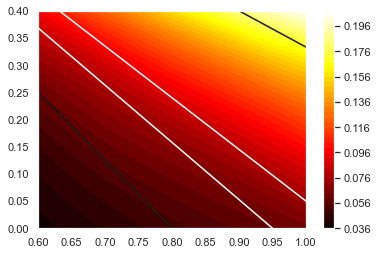

11

In [112]:
# Se deben aplicar todas las mejoras que se apliquen en el bloque anterior

fig, ax = plt.subplots()

# Se debe tener en cuenta que aux1 almacena las diferencias entre las pérdidas de convertidor con los MOSFETs envejecidos
# (aux_M1, aux_M2,...) y las pérdidas calculadas en el bloque anterior, que son con los MOSFETs sin envejecer (aux)
aux1=[ [ 0 for i in range(size_D1) ] for j in range(size_D2) ] #create empty matrix of size D2,D1
for j in range(size_D2):
    for i in range(size_D1):
        c=currents_L(L_ind,Vin_f(Vbus,D1_r[i],D2_r[j]),Vbus,P/Vin_f(Vbus,D1_r[i],D2_r[j]),D1_r[i],D2_r[j],phi_bob,T)
        interv=intervals(D1_r[i],D2_r[j],phi_bob,T)
        Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1_r[i],D2_r[j],phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
        aux_M1=Losses_M1(D1_r[i],Vin_f(Vbus,D1_r[i],D2_r[j]),c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
        aux_M2=Losses_M2(D1_r[i],Vin_f(Vbus,D1_r[i],D2_r[j]),c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,1)
        aux_M3=Losses_M3(D2_r[j],Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,1)
        aux_M4=Losses_M4(D2_r[j],Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,1)
        aux_protM1=Losses_prot(Mprot_index,Irms_M1,1)
        aux_protM3=Losses_prot(Mprot_index,Irms_M3,1)
        Iac_ind=max(c)-min(c)
        Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
        aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
        aux1[j][i]=aux_M1+aux_M2+aux_M3+aux_M4+aux_L-aux[j][i]

#Plot the surface.
gr=ax.contourf(D1_r, D2_r, aux1, 50, cmap='hot')
fig.colorbar(gr)

ax.plot(D1_r,D2_f(Vbus,Vsa_max,D1_r),'k')
ax.plot(D1_r,D2_f(Vbus,Vsa_min,D1_r),'k')

# Esta líneas indican el máximo y mínimo que podrían cubrirse cuando el ciclo de trabajo D1 o D2 ya no pueden crecen más (95%)
ax.plot(D1_r,D2_f(Vbus,Lim_sup_D1*Vbus,D1_r),'w')
ax.plot(D1_f(Vbus*(1-Lim_inf_D2),Vbus,D2_r),D2_r,'w')


#ax.plot(D1_r,D2_r,'g')
plt.xlim(D1_min_sh,D1_max_sh)
plt.ylim(D2_min_sh,D2_max_sh)

plt.show()

#Eje Y es D2 y Eje X es D1

size_D2

###### [ONLY CONSIDERING MOSFET LOSSES] It makes sense that an increment in the Rdson of M1 (Buck MOSFET) gives the above result. As  D1 is increased, while keeping D2 constant, means that the static gain is increased. The output voltage remains constant, so the input voltage is decreased. As it is decreased, the current is increased, and it is driven for more time. Consequently, the conduction losses are increased.
###### In the same way, if D1 is fixed and D2 is increased, the input voltage is decreased, so for the same reason, conduction losses are increased.
###### Both effects combined, lead to the diagonal in the differential losses.
En general, cambiando los valores de MOSFET escogidos, se puede ver que las diferencias (evoluciones de rendimientos) cambian. Por lo tanto, es posible discernir, en función del plano de rendimientos, qué está pasando con las Rdson.

# Health Monitoring sobre el modelo desarrollado

## Definición de funciones empleadas en esta sección

In [16]:
def aging_estimation(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini,error):
    muestra_r=[0 for gainr in range(elements)]
    muestra=[0 for gainr in range(elements)]
    gain_count=-1

    # Se toma una muestra de la diferencia entre un convertidor sano y uno envejecido según los coeficientes de arriba (muestra)
    # y la misma muestra con errores aleatorios (muestra_r) debido a medida con un máximo de (error%)
    for gain in gainr:#variación de Gain
        gain_count=gain_count+1
        muestra[gain_count]=aging_data[coef_1_ini][coef_2_ini][coef_3_ini][coef_4_ini][gain_count]-aging_data[0][0][0][0][gain_count]
        muestra_r[gain_count]=muestra[gain_count]*(1+random.randint(-error, error)/1000)


    # Se busca por mínimos cuadrados la combinación de coefficentes que más aproximan el modelo a la muestra con errores de medición a
    # Es importante resaltarque no se ha hecho con el modelo matemático, sino explorando la matrix de reusltados que se han sacado
    # con el modelo. Básicamente es lo mismo, pero sería bueno explorar si a partir de las ecuaciones se puede ganar algo.
    error_smaller=100000000000.0
    
    for g in range(aging_steps):#variación de RDSON1
        for h in range(aging_steps):#Variación de RDSON2
                for i in range(aging_steps):#Variación de RDSON3
                        for j in range(aging_steps):#Variación de RDSON4
                            error=0.0
                            gain_count=-1
                            for gain in gainr:#variación de Gain
                                gain_count=gain_count+1                         
                                error=error+(muestra_r[gain_count]-(aging_data[g][h][i][j][gain_count]-aging_data[0][0][0][0][gain_count]))**2

                            if (error<error_smaller):
                                error_smaller=error
                                coef_1_out=g
                                coef_2_out=h
                                coef_3_out=i
                                coef_4_out=j
    return coef_1_out,coef_2_out,coef_3_out,coef_4_out,muestra,muestra_r

## Evolución de las pérdidas a lo largo de la línea de rendimiento óptimo
###### Se debe tener en cuenta que podría fijarse cualquier punto de funcionamiento siempre que la ganancia sea la deseada. (pendiente de la línea que une el punto de funcionamiento con el punto de la gráfica [0,1] (sobre el eje Y ). Si no pudiese fijjarse y se debiera operar siempre en la zona de rendimiento máximo, es interesante ver si la línea de funcionamiento a lo largo del rendimiento máximo es también una buena medida de las variaciones y permite predecir qué RDson está subiendo más de la cuenta.

### Definición de valores para esta sección

In [17]:
gain_min=Vbus/Vsa_max
gain_max=Vbus/Vsa_min
gain_vert=D1_max/(1-0) #Máxima ganancia que se puede conseguir operando con D2=0 (modo Buck)
gain_horz=1/(1-D2_min) #Mínima ganancia que se puede conseguir operando con D1=1 (modo Boost)


(0.95, 1.0526315789473684)

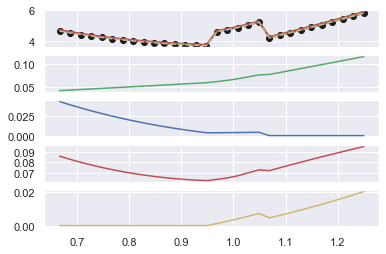

In [98]:
# Se deja de representar un plano de pérdidas en fucnión de D1 y D2. Se supone que el convertidor operará con ciclo
# de trabajo D1=1 o D2=0. Si no pudiese, se fijará un D1=0.95 o un D2=0.05 hasta q ue se pueda volver a la condición
# de D1=1 o D2=0. Esto es lo que se plantea en el artículo con las posubles estrategias de conmutación.


#evejecimiento normal

i=0
losses=[0 for i in range(elements)]
gainr=np.linspace(gain_min,gain_max,elements)
for gain in gainr:
    if (gain<gain_vert):
        D2x=0
        D1x=gain 
    elif(gain<gain_horz):
        D1x=D1_max
        D2x=1-D1x/gain
    else:
        D1x=1
        D2x=1-D1x/gain

    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses[i]=aux
    i=i+1

#Envejecimiento anormal del MOSFET 1


i=0
losses1=[0 for i in range(elements)] 
diff1=[0 for i in range(elements)]

#Se barre para distintos valores de ganancia, desde gain_min hasta gain_max. Se debe mirar si estamos en el margen
# de ganaicas que no se puede conseguir con modo Boost o Buck. SI estamos en ese margen, se ha supuesto que
# se fija D1=D1_max y se varía D2. Cuando se puede llegar a a tener la ganacia deseada fijando D1=1, pues se pasa a
# ese modo y se varía D2. No es lo óptimo y se podría optimizar, de forma que cuando D2 sea 0.05 asumiendo D1=1, ya se
# pase a modo a Boost.Ahora mismo, se opera en modo Buck Boost hasta que su ganancia asumiendo D1=0.95 sea 1/(1-0.05), por
# lo que D2 será mayor de 0.05 cuando se pase a modo Boost.
for gain in gainr:
    if (gain<gain_vert):
        D2x=0
        D1x=gain
    elif(gain<gain_horz):
        D1x=D1_max
        D2x=1-D1x/gain
    else:
        D1x=1
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)    
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging_extra)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses1[i]=aux1
    diff1[i]=losses1[i]-losses[i]
    i=i+1

#Envejecimiento anormal del MOSFET 2

i=0
losses2=[0 for i in range(elements)] 
diff2=[0 for i in range(elements)]
for gain in gainr:
    if (gain<gain_vert):
        D2x=0
        D1x=gain
    elif(gain<gain_horz):
        D1x=D1_max
        D2x=1-D1x/gain
    else:
        D1x=1
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T) 
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging_extra)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses2[i]=aux1
    diff2[i]=losses2[i]-losses[i]
    i=i+1

#Envejecimiento anormal del MOSFET 3
   
i=0
losses3=[0 for i in range(elements)] 
diff3=[0 for i in range(elements)]
for gain in gainr:
    if (gain<gain_vert):
        D2x=0
        D1x=gain
    elif(gain<gain_horz):
        D1x=D1_max
        D2x=1-D1x/gain
    else:
        D1x=1
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)    
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging_extra)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses3[i]=aux1
    diff3[i]=losses3[i]-losses[i]
    i=i+1

    #Envejecimiento anormal del MOSFET 4


i=0
losses4=[0 for i in range(elements)] 
diff4=[0 for i in range(elements)]
for gain in gainr:
    if (gain<gain_vert):
        D2x=0
        D1x=gain
    elif(gain<gain_horz):
        D1x=D1_max
        D2x=1-D1x/gain
    else:
        D1x=1
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)    
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging_extra)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses4[i]=aux1
    diff4[i]=losses4[i]-losses[i]
    i=i+1
    
fig, ax = plt.subplots(5)

ax[0].plot(gainr,losses,'ko')
ax[0].plot(gainr,losses1,'g')
ax[0].plot(gainr,losses2,'b')
ax[0].plot(gainr,losses3,'r')
ax[0].plot(gainr,losses4,'y--')


ax[1].plot(gainr,diff1,'g')
ax[2].plot(gainr,diff2,'b')
ax[3].plot(gainr,diff3,'r')
ax[4].plot(gainr,diff4,'y')

gain_vert,gain_horz

La variación de pérdidas en función de la ganancia

REVISAR EL ARTÏCULO Online Health Monitoring in Digitally Controlled Power Converters


https://realpython.com/linear-regression-in-python/#what-is-regression

¿Qué quiero hacer?
Yo puedo calcular datos por un modelo complejo de cómo evoluciona la curva de pérdidas en función de la ganancia según se van envejeciendo los MOSFETs por independiente. Sería un modelo 3D donde el eje X es ganacia, como las gráficas de arriba y el eje Y es la variación de Rdson MOSFET1, por ejemplo. Sacaría, con cada MOSFET. un plano, para un total de 4.
Podría sacar una función de pérdidas por mínimos cuadrados tomando puntos en cada uno de esos planos, para un total de 4 funciones dependientes de Rdsoni y ganancia.
Las pérdidas totales no serían la suma de las cuatro funciones. Esas 4 funciones, menos las pérdidas de base, serían el incremento.

### Generación de matriz datos por MOSFET de cómo cambian las pérdidas



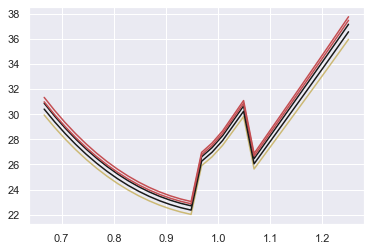

In [19]:
aging_data=[[[[[0 for gainr in range(elements)] for j in range(aging_steps)] for i in range(aging_steps)] for h in range(aging_steps)] for g in range(aging_steps) ]

for g in range(aging_steps):#variación de RDSON1
    for h in range(aging_steps):#Variación de RDSON2
            for i in range(aging_steps):#Variación de RDSON3
                    for j in range(aging_steps):#Variación de RDSON4
                        gain_count=-1
                        for gain in gainr:#variación de Gain
                            gain_count=gain_count+1
                            if (gain<gain_vert):
                                D2x=0
                                D1x=gain
                            elif(gain<gain_horz):
                                D1x=D1_max
                                D2x=1-D1x/gain
                            else:
                                D1x=1
                                D2x=1-D1x/gain


                            c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
                            interv=intervals(D1x,D2x,phi_bob,T)
                            Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

                            aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,1+g/aging_steps*aging_max)
                            aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,1+h/aging_steps*aging_max)
                            aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,1+i/aging_steps*aging_max)
                            aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,1+j/aging_steps*aging_max)
                            Iac_ind=max(c)-min(c)
                            Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
                            aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
                            aging_data[g][h][i][j][gain_count]=aux_M1+aux_M2+aux_M3+aux_M4+aux_L

fig, ax = plt.subplots()

ax.plot(gainr,aging_data[0][0][0][0],'y')
ax.plot(gainr,aging_data[1][1][1][1],'k')
ax.plot(gainr,aging_data[2][2][2][2],'k')
ax.plot(gainr,aging_data[3][3][3][3],'r')
ax.plot(gainr,aging_data[3][2][2][2],'r')

# Ya tengo una base de datos con todos los posibles valores de pérdidas en función del envejecimiento de cada MOSFET.
# aux1[age_MOSFET1][age_MOSFET2][age_MOSFET3][Age_MOSFET4][gain]
# Se tienen n edades de envejecimiento para cada MOSFET



### Ejemplo de un envejecimiento determinado y estimación de sus coeficientes

In [20]:
coef_1_ini=5
coef_2_ini=2
coef_3_ini=2
coef_4_ini=5

5 2 2 5
5 2 2 5


0.02

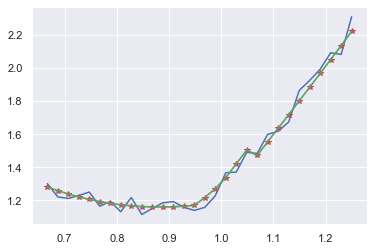

In [21]:
# Hacerlo, epro sobre los deltas de pérdidas, y no sobre las pérdidas en sí
# Vamos a tomar pérdidas para ganancuia de forma experimental. tendremos un conjunto de n puntos que definen la evolución
# de las pérdidas en gunción de gain para unos MOSFETs cuyo estado envejecido se desconoce.
# Luego vamos a analizar el error cuadrático medio asumiendo todas las combinaciones posibles de envejecimientos


muestra_r=[0 for gainr in range(elements)]
muestra=[0 for gainr in range(elements)]

coef_1,coef_2,coef_3,coef_4,muestra,muestra_r=aging_estimation(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini,error_sense)

fig, ax = plt.subplots() 
gain_count=-1
show_fig=[0 for gainr in range(elements)]
show_fig_real=[0 for gainr in range(elements)]
for gain in gainr:#variación de Gain
    gain_count=gain_count+1                         
    show_fig[gain_count]=aging_data[coef_1][coef_2][coef_3][coef_4][gain_count]-aging_data[0][0][0][0][gain_count]
    show_fig_real[gain_count]=aging_data[coef_1_ini][coef_2_ini][coef_3_ini][coef_4_ini][gain_count]-aging_data[0][0][0][0][gain_count]
    
#valor real
ax.plot(gainr,muestra,'y')

#Valor real pero con erroe en medidas
ax.plot(gainr,muestra_r,'b')

#Valor según los coeficientes estimados
ax.plot(gainr,show_fig,'r*')

# Valor según los coeficientes iniciales
ax.plot(gainr,show_fig_real,'g')

print(coef_1,coef_2,coef_3,coef_4)
print(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini)

# los errores en la estimación son los siguientes:
error_max_estimación=(1+abs(coef_4-coef_4_ini))*aging_max/aging_steps
error_max_estimación

### Generación de 10 casos aleatorios de envejecimiento y errores de estimación resultantes

In [22]:
muestra_r=[0 for gainr in range(elements)]
muestra=[0 for gainr in range(elements)]
error_max_1=[0 for test in range(10)]
error_max_2=[0 for test in range(10)]
error_max_3=[0 for test in range(10)]
error_max_4=[0 for test in range(10)]
for test in range(10):
    coef_1_ini=random.randint(0,aging_steps-1)
    coef_2_ini=random.randint(0,aging_steps-1)
    coef_3_ini=random.randint(0,aging_steps-1)
    coef_4_ini=random.randint(0,aging_steps-1)
    coef_1,coef_2,coef_3,coef_4,muestra,muestra_r=aging_estimation(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini,error_sense)

#Se calculan los errores de estimación como un porcentaje respecto al error máximo.
    error_max_1[test]=int((0+abs(coef_1-coef_1_ini))*aging_max/aging_steps*100/aging_max)
    error_max_2[test]=int((0+abs(coef_2-coef_2_ini))*aging_max/aging_steps*100/aging_max)
    error_max_3[test]=int((0+abs(coef_3-coef_3_ini))*aging_max/aging_steps*100/aging_max)
    error_max_4[test]=int((0+abs(coef_4-coef_4_ini))*aging_max/aging_steps*100/aging_max)


error_max_1, error_max_2, error_max_3, error_max_4

# En general, la estimaciones siempre fallan más sobre el Mosfet M4, y luego sobre el MOSFET 2.


([33, 0, 0, 0, 16, 0, 33, 16, 0, 0],
 [33, 0, 0, 0, 16, 0, 33, 16, 0, 0],
 [33, 0, 0, 0, 16, 0, 33, 16, 0, 0],
 [66, 0, 0, 0, 16, 16, 66, 0, 0, 0])

## Evolución de las pérdidas a lo largo de línea de ganacia predefinida


In [23]:
gain_min=Vbus/Vsa_max
gain_max=Vbus/Vsa_min

gain_change=D1_nom/(1-D2_nom)

(0.8, 0.2, 1.0)

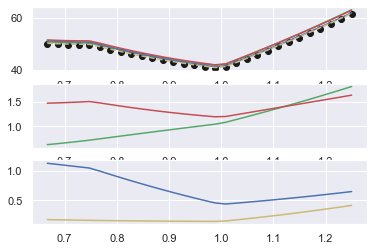

In [24]:
# Se deja de representar un plano de pérdidas en fucnión de D1 y D2. Se supone que el convertidor operará con ciclo
# de trabajo D2 determinado hasta entrar en la zona prohibida...en ese momento opera como el modelo anterior hasta que D1 puede ser 

aging_data=[[[[[0 for gainr in range(elements)] for j in range(aging_steps)] for i in range(aging_steps)] for h in range(aging_steps)] for g in range(aging_steps) ]

#evejecimiento normal
i=0
losses=[0 for i in range(elements)]
gainr=np.linspace(gain_min,gain_max,elements)
for gain in gainr:
    if (gain<gain_change):
        D2x=D2_nom
        D1x=(1-D2x)*gain
    else:
        D1x=D1_nom
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses[i]=aux
    i=i+1
    
#Envejecimiento anormal del MOSFET 1

i=0
losses1=[0 for i in range(elements)] 
diff1=[0 for i in range(elements)]

#Se barre para distintos valores de ganancia, desde gain_min hasta gain_max. Se debe mirar si estamos en el margen
# de ganaicas que no se puede conseguir con modo Boost o Buck. SI estamos en ese margen, se ha supuesto que
# se fija D1=D1_max y se varía D2. Cuando se puede llegar a a tener la ganacia deseada fijando D1=1, pues se pasa a
# ese modo y se varía D2. No es lo óptimo y se podría optimizar, de forma que cuando D2 sea 0.05 asumiendo D1=1, ya se
# pase a modo a Boost.Ahora mismo, se opera en modo Buck Boost hasta que su ganancia asumiendo D1=0.95 sea 1/(1-0.05), por
# lo que D2 será mayor de 0.05 cuando se pase a modo Boost.
for gain in gainr:
    if (gain<gain_change):
        D2x=D2_nom
        D1x=(1-D2x)*gain
    else:
        D1x=D1_nom
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)    
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging_extra)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses1[i]=aux1
    diff1[i]=losses1[i]-losses[i]
    i=i+1
    
#Envejecimiento anormal del MOSFET 2

i=0
losses2=[0 for i in range(elements)] 
diff2=[0 for i in range(elements)]
for gain in gainr:
    if (gain<gain_change):
        D2x=D2_nom
        D1x=(1-D2x)*gain
    else:
        D1x=D1_nom
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)    
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging_extra)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses2[i]=aux1
    diff2[i]=losses2[i]-losses[i]
    i=i+1

#Envejecimiento anormal del MOSFET 3
   
i=0
losses3=[0 for i in range(elements)] 
diff3=[0 for i in range(elements)]
for gain in gainr:
    if (gain<gain_change):
        D2x=D2_nom
        D1x=(1-D2x)*gain
    else:
        D1x=D1_nom
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)    
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging_extra)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses3[i]=aux1
    diff3[i]=losses3[i]-losses[i]
    i=i+1

    #Envejecimiento anormal del MOSFET 4


i=0
losses4=[0 for i in range(elements)] 
diff4=[0 for i in range(elements)]
for gain in gainr:
    if (gain<gain_change):
        D2x=D2_nom
        D1x=(1-D2x)*gain
    else:
        D1x=D1_nom
        D2x=1-D1x/gain
        
    c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)    
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging_extra)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses4[i]=aux1
    diff4[i]=losses4[i]-losses[i]
    i=i+1    
    
    

fig, ax = plt.subplots(3)

ax[0].plot(gainr,losses,'ko')
ax[0].plot(gainr,losses1,'g')
ax[0].plot(gainr,losses2,'b')
ax[0].plot(gainr,losses3,'r')
ax[0].plot(gainr,losses4,'y--')


ax[1].plot(gainr,diff1,'g')
ax[2].plot(gainr,diff2,'b')
ax[1].plot(gainr,diff3,'r')
ax[2].plot(gainr,diff4,'y')

D1_nom,D2_nom, gain_change

### Generación de matriz datos por MOSFET de cómo cambian las pérdidas (para D2nom)

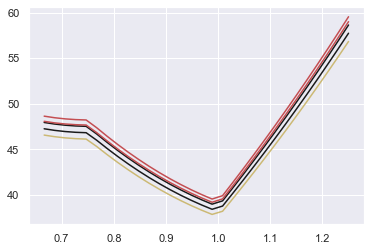

In [25]:
aging_data=[[[[[0 for gainr in range(elements)] for j in range(aging_steps)] for i in range(aging_steps)] for h in range(aging_steps)] for g in range(aging_steps) ]

for g in range(aging_steps):#variación de RDSON1
    for h in range(aging_steps):#Variación de RDSON2
            for i in range(aging_steps):#Variación de RDSON3
                    for j in range(aging_steps):#Variación de RDSON4
                        gain_count=-1
                        for gain in gainr:
                            gain_count=gain_count+1                         

                            if (gain<gain_change):
                                D2x=D2_nom
                                D1x=(1-D2x)*gain
                            else:
                                D1x=D1_nom
                                D2x=1-D1x/gain


                            c=currents_L(L_ind,Vbus/gain,Vbus,P/(Vbus/gain),D1x,D2x,phi_bob,T)
                            interv=intervals(D1x,D2x,phi_bob,T)    
                            Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
    
                            aux_M1=Losses_M1(D1x,Vbus/gain,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr, Irms_M1,1+g/aging_steps*aging_max)
                            aux_M2=Losses_M2(D1x,Vbus/gain,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,1+h/aging_steps*aging_max)
                            aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr, Irms_M3,1+i/aging_steps*aging_max)
                            aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr, Irms_M4,1+j/aging_steps*aging_max)
                            Iac_ind=max(c)-min(c)
                            Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
                            aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
                            aging_data[g][h][i][j][gain_count]=aux_M1+aux_M2+aux_M3+aux_M4+aux_L

fig, ax = plt.subplots()

ax.plot(gainr,aging_data[0][0][0][0],'y')
ax.plot(gainr,aging_data[1][1][1][1],'k')
ax.plot(gainr,aging_data[2][2][2][2],'k')
ax.plot(gainr,aging_data[3][3][3][3],'r')
ax.plot(gainr,aging_data[3][2][2][2],'r')

# Ya tengo una base de datos con todos los posibles valores de pérdidas en función del envejecimiento de cada MOSFET.
# aux1[age_MOSFET1][age_MOSFET2][age_MOSFET3][Age_MOSFET4][gain]
# Se tienen n edades de envejecimiento para cada MOSFET

### Ejemplo de uso

In [26]:
coef_1_ini=5
coef_2_ini=2
coef_3_ini=3
coef_4_ini=5

5 2 3 5
5 2 3 5


0.02

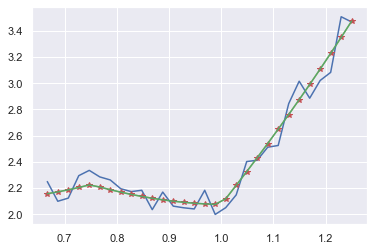

In [27]:
# Hacerlo, epro sobre los deltas de pérdidas, y no sobre las pérdidas en sí
# Vamos a tomar pérdidas para ganancuia de forma experimental. tendremos un conjunto de n puntos que definen la evolución
# de las pérdidas en gunción de gain para unos MOSFETs cuyo estado envejecido se desconoce.
# Luego vamos a analizar el error cuadrático medio asumiendo todas las combinaciones posibles de envejecimientos



muestra_r=[0 for gainr in range(elements)]
muestra=[0 for gainr in range(elements)]

coef_1,coef_2,coef_3,coef_4,muestra,muestra_r=aging_estimation(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini,error_sense)

fig, ax = plt.subplots() 
gain_count=-1
show_fig=[0 for gainr in range(elements)]
show_fig_real=[0 for gainr in range(elements)]
for gain in gainr:#variación de Gain
    gain_count=gain_count+1                         
    show_fig[gain_count]=aging_data[coef_1][coef_2][coef_3][coef_4][gain_count]-aging_data[0][0][0][0][gain_count]
    show_fig_real[gain_count]=aging_data[coef_1_ini][coef_2_ini][coef_3_ini][coef_4_ini][gain_count]-aging_data[0][0][0][0][gain_count]
    
#valor real
ax.plot(gainr,muestra,'y')

#Valor real pero con erroe en medidas
ax.plot(gainr,muestra_r,'b')

#Valor según los coeficientes estimados
ax.plot(gainr,show_fig,'r*')

# Valor según los coeficientes iniciales
ax.plot(gainr,show_fig_real,'g')

print(coef_1,coef_2,coef_3,coef_4)
print(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini)

# los errores en la estimación son los siguientes:
error_max_estimación=(1+abs(coef_4-coef_4_ini))*aging_max/aging_steps
error_max_estimación

### Análisis de 10 casos de estudio

In [28]:
error_max_1=[0 for test in range(10)]
error_max_2=[0 for test in range(10)]
error_max_3=[0 for test in range(10)]
error_max_4=[0 for test in range(10)]
muestra_r=[0 for gainr in range(elements)]
muestra=[0 for gainr in range(elements)]
for test in range(10):
    coef_1_ini=random.randint(0,aging_steps-1)
    coef_2_ini=random.randint(0,aging_steps-1)
    coef_3_ini=random.randint(0,aging_steps-1)
    coef_4_ini=random.randint(0,aging_steps-1)
    coef_1,coef_2,coef_3,coef_4,muestra,muestra_r=aging_estimation(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini,error_sense)

#Se calculan los errores de estimación como un porcentaje respecto al error máximo.
    error_max_1[test]=int((0+abs(coef_1-coef_1_ini))*aging_max/aging_steps*100/aging_max)
    error_max_2[test]=int((0+abs(coef_2-coef_2_ini))*aging_max/aging_steps*100/aging_max)
    error_max_3[test]=int((0+abs(coef_3-coef_3_ini))*aging_max/aging_steps*100/aging_max)
    error_max_4[test]=int((0+abs(coef_4-coef_4_ini))*aging_max/aging_steps*100/aging_max)


error_max_1, error_max_2, error_max_3, error_max_4

# En general, la estimaciones siempre fallan más sobre el Mosfet M4, y luego sobre el MOSFET 2.

([16, 0, 16, 33, 0, 33, 0, 0, 0, 0],
 [16, 0, 16, 33, 0, 33, 0, 0, 0, 0],
 [16, 0, 16, 33, 0, 33, 0, 0, 0, 0],
 [33, 0, 33, 66, 0, 66, 0, 0, 0, 0])

## Análisis de evolución sobre una línea de ganacia fija pero duties cambiantes 

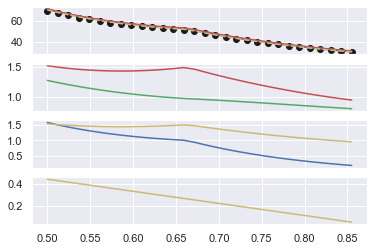

In [29]:
gain_nom=0.9
Vin_nom=Vbus/gain_nom

#evejecimiento normal


i=0
losses=[0 for i in range(elements)]
D1_r=np.linspace(0.5,gain_nom*(1-D2_min),elements)
D2_r=D2_f(Vin_nom,Vbus,D1_r)
for D1x in D1_r:
    D2x=D2_f(Vin_nom,Vbus,D1x)
    c=currents_L(L_ind,Vbus/gain_nom,Vbus,P/Vin_nom,D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain_nom,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain_nom,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses[i]=aux
    i=i+1

#Envejecimiento anormal del MOSFET 1
i=0
losses1=[0 for i in range(elements)] 
diff1=[0 for i in range(elements)]
for D1x in D1_r:
    D2x=D2_f(Vin_nom,Vbus,D1x)
    c=currents_L(L_ind,Vbus/gain_nom,Vbus,P/Vin_nom,D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain_nom,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging_extra)
    aux_M2=Losses_M2(D1x,Vbus/gain_nom,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses1[i]=aux1
    diff1[i]=losses1[i]-losses[i]
    i=i+1

#Envejecimiento anormal del MOSFET 2
i=0
losses2=[0 for i in range(elements)] 
diff2=[0 for i in range(elements)]

for D1x in D1_r:
    D2x=D2_f(Vin_nom,Vbus,D1x)
    c=currents_L(L_ind,Vbus/gain_nom,Vbus,P/Vin_nom,D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain_nom,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain_nom,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging_extra)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses2[i]=aux1
    diff2[i]=losses2[i]-losses[i]
    i=i+1

#Envejecimiento anormal del MOSFET 3
i=0
losses3=[0 for i in range(elements)] 
diff3=[0 for i in range(elements)]

for D1x in D1_r:
    D2x=D2_f(Vin_nom,Vbus,D1x)
    c=currents_L(L_ind,Vbus/gain_nom,Vbus,P/Vin_nom,D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain_nom,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain_nom,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging_extra)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses3[i]=aux1
    diff3[i]=losses3[i]-losses[i]
    i=i+1

#Envejecimiento anormal del MOSFET 4
losses4=[0 for i in range(elements)] 
diff4=[0 for i in range(elements)]
i=0
for D1x in D1_r:
    D2x=D2_f(Vin_nom,Vbus,D1x)
    c=currents_L(L_ind,Vbus/gain_nom,Vbus,P/Vin_nom,D1x,D2x,phi_bob,T)
    interv=intervals(D1x,D2x,phi_bob,T)
    Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])

    aux_M1=Losses_M1(D1x,Vbus/gain_nom,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging)
    aux_M2=Losses_M2(D1x,Vbus/gain_nom,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging)
    aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging)
    aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging_extra)
    Iac_ind=max(c)-min(c)
    Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
    aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
    aux1=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
    losses4[i]=aux1
    diff4[i]=losses3[i]-losses[i]
    i=i+1

    

fig, ax = plt.subplots(4)

ax[0].plot(D1_r,losses,'ko')
ax[0].plot(D1_r,losses1,'g')
ax[0].plot(D1_r,losses2,'b')
ax[0].plot(D1_r,losses3,'r')
ax[0].plot(D1_r,losses4,'y--')


ax[1].plot(D1_r,diff1,'g')
ax[2].plot(D1_r,diff2,'b')
ax[1].plot(D1_r,diff3,'r')
ax[2].plot(D1_r,diff4,'y')
ax[3].plot(D1_r,D2_f(Vin_nom,Vbus,D1_r),'y')

In [30]:
[ [ 0 for i in range(3) ] for j in range(3)]
print i
    print j
    

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(i)? (<ipython-input-30-94bec2f8473d>, line 2)

In [47]:
[0 for b in range(2)]:
    print(b)


SyntaxError: invalid syntax (<ipython-input-47-e7ec4e17677b>, line 1)

In [48]:
currucu=[ [ 0 for plas in range(size_D1) ] for plis in range(size_D2) ]

In [49]:

currucu


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
np.zeros(shape=(size_D2,size_D1))

Es interesante comprobar que la precisión del método depende mucho del D2_nom que se escoja. 